In [2]:
import pandas as pd

# Load CSV from uploaded file
df = pd.read_csv('T1.csv')
df.head()


,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load your data
df = pd.read_csv('T1.csv')  # Replace with your file path

# 2. Rename columns for ease
df.columns = ['Date', 'ActivePower', 'WindSpeed', 'TheoreticalPower', 'WindDirection']

# 3. Drop missing values
df.dropna(inplace=True)

# 4. Calculate error between actual and expected power
df['PowerError'] = np.abs(df['ActivePower'] - df['TheoreticalPower'])

# 5. Define threshold for labeling
# This is flexible – adjust based on histogram or domain knowledge
df['Status'] = 0.0  # Default: Normal
df.loc[df['PowerError'] > 200, 'Status'] = 0.5  # Warning
df.loc[df['PowerError'] > 400, 'Status'] = 1.0  # Fault
df.to_csv('wind_cleaned_labeled.csv', index=False)


In [5]:
from sklearn.preprocessing import MinMaxScaler

# Select condition attributes to fuzzify
condition_features = ['WindSpeed', 'ActivePower', 'TheoreticalPower', 'PowerError']

# Step 1: Normalize [0, 1]
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(df[condition_features]), columns=[f"{col}_theta" for col in condition_features])

# Step 2: Compute pessimism value (phi)
for col in condition_features:
    theta_col = f"{col}_theta"
    phi_col = f"{col}_phi"
    df_norm[phi_col] = (1 - df_norm[theta_col]) / (1 + df_norm[theta_col])

# Step 3: Merge back into main dataframe
df_full = pd.concat([df, df_norm], axis=1)
# Show first 5 rows to check output
print(df_full.head())

# Optional: save the result
df_full.to_csv("wind_fuzzy_normalized.csv", index=False)

               Date  ActivePower  WindSpeed  TheoreticalPower  WindDirection  \
0  01 01 2018 00:00   380.047791   5.311336        416.328908     259.994904   
1  01 01 2018 00:10   453.769196   5.672167        519.917511     268.641113   
2  01 01 2018 00:20   306.376587   5.216037        390.900016     272.564789   
3  01 01 2018 00:30   419.645905   5.659674        516.127569     271.258087   
4  01 01 2018 00:40   380.650696   5.577941        491.702972     265.674286   

   PowerError  Status  WindSpeed_theta  ActivePower_theta  \
0   36.281117     0.0         0.210717           0.105633   
1   66.148316     0.0         0.225032           0.125991   
2   84.523429     0.0         0.206936           0.085289   
3   96.481664     0.0         0.224537           0.116568   
4  111.052276     0.0         0.221294           0.105800   

   TheoreticalPower_theta  PowerError_theta  WindSpeed_phi  ActivePower_phi  \
0                0.115647          0.010078       0.651914         0.8089

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

# Step 1: Load cleaned CSV
df = pd.read_csv("wind_fuzzy_normalized.csv")

# Step 2: Select optimistic (theta) and pessimistic (phi) membership columns
theta_columns = ['WindSpeed_theta', 'ActivePower_theta', 'TheoreticalPower_theta', 'PowerError_theta' ]
phi_columns = ['WindSpeed_phi', 'ActivePower_phi', 'TheoreticalPower_phi', 'PowerError_phi']
criteria = ['WindSpeed', 'ActivePower', 'TheoreticalPower', 'PowerError']

# Step 3: Function to compute normalized entropy
def compute_entropy(values):
    values = np.clip(values, 1e-6, None)  # Avoid division by zero
    p = values / np.sum(values)
    return entropy(p) / np.log(len(values))  # Normalize entropy to [0,1]

# Step 4: Calculate entropy for theta and phi
E_theta = {}
E_phi = {}

for i, crit in enumerate(criteria):
    E_theta[crit] = compute_entropy(df[theta_columns[i]].values)
    E_phi[crit] = compute_entropy(df[phi_columns[i]].values)

# Step 5: Calculate average entropy
E_avg = {c: (E_theta[c] + E_phi[c]) / 2 for c in criteria}

# Step 6: Compute weights
raw_weights = {c: 1 - E_avg[c] for c in criteria}
total = sum(raw_weights.values())
weights = {c: raw_weights[c] / total for c in criteria}

# Step 7: Print results
print("=== Optimism Entropy (E_theta) ===")
for c in criteria:
    print(f"{c}: {E_theta[c]:.4f}")

print("\n=== Pessimism Entropy (E_phi) ===")
for c in criteria:
    print(f"{c}: {E_phi[c]:.4f}")

print("\n=== Average Entropy (Ē) ===")
for c in criteria:
    print(f"{c}: {E_avg[c]:.4f}")

print("\n=== Final Normalized Weights ===")
for c in criteria:
    print(f"{c}: {weights[c]:.4f}")

=== Optimism Entropy (E_theta) ===
WindSpeed: 0.9852
ActivePower: 0.9481
TheoreticalPower: 0.9550
PowerError: 0.9017

=== Pessimism Entropy (E_phi) ===
WindSpeed: 0.9942
ActivePower: 0.9735
TheoreticalPower: 0.9668
PowerError: 0.9984

=== Average Entropy (Ē) ===
WindSpeed: 0.9897
ActivePower: 0.9608
TheoreticalPower: 0.9609
PowerError: 0.9501

=== Final Normalized Weights ===
WindSpeed: 0.0743
ActivePower: 0.2830
TheoreticalPower: 0.2821
PowerError: 0.3606


In [7]:
import pandas as pd
import numpy as np

# Step 1: Load preprocessed data
df = pd.read_csv("wind_fuzzy_normalized.csv")
df = df.head(1000)

# Step 2: Clip small values for numerical safety
epsilon = 1e-8
theta_cols = ['WindSpeed_theta', 'ActivePower_theta', 'TheoreticalPower_theta', 'PowerError_theta']
phi_cols   = ['WindSpeed_phi',   'ActivePower_phi',   'TheoreticalPower_phi',   'PowerError_phi']
criteria   = ['WindSpeed', 'ActivePower', 'TheoreticalPower', 'PowerError']

for col in theta_cols + phi_cols:
    df[col] = df[col].clip(lower=epsilon)

# Step 3: Load entropy-based weights
weights = {
    'WindSpeed': 0.0743,
    'ActivePower': 0.2830,
    'TheoreticalPower': 0.2821,
    'PowerError': 0.3606,
}
weight_vector = np.array([weights[c] for c in criteria])

# Step 4: Extract fuzzy matrices
theta_matrix = df[theta_cols].values
phi_matrix   = df[phi_cols].values
num_alternatives = len(df)

# Step 5: Compute similarity matrix
similarity_matrix = np.zeros((num_alternatives, num_alternatives))

print("🌀 Computing similarity matrix...")
for i in range(num_alternatives):
    theta_i = theta_matrix[i]
    phi_i = phi_matrix[i]

    # Broadcasting for theta_i and phi_i
    theta_sqrt = np.sqrt(theta_matrix * theta_i[np.newaxis, :])
    phi_sqrt   = np.sqrt(phi_matrix * phi_i[np.newaxis, :])

    sim_k = (theta_sqrt + phi_sqrt) / 2.0
    sim_ij = sim_k @ weight_vector  # Final weighted similarity (shape: 1000,)

    similarity_matrix[i] = sim_ij

    if i % 500 == 0 or i == num_alternatives - 1:
        print(f"✅ Processed row {i + 1} of {num_alternatives}")

np.fill_diagonal(similarity_matrix, 1.0)

# Step 6: Save to DataFrame
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df.index.name = "u_i"
similarity_df.columns = [f"u_{j}" for j in range(num_alternatives)]

# Step 7: Save file
similarity_df.to_csv("similarity_matrix.csv", index=True)
print("\n✅ Similarity matrix saved as 'similarity_matrix.csv'.")

🌀 Computing similarity matrix...
✅ Processed row 1 of 1000
✅ Processed row 501 of 1000
✅ Processed row 1000 of 1000

✅ Similarity matrix saved as 'similarity_matrix.csv'.


In [8]:
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df.index.name = 'u_i'
similarity_df.columns = [f'u_{j}' for j in range(num_alternatives)]

# Show top 5×5 similarity matrix
print(similarity_df.iloc[:5, :5])

          u_0       u_1       u_2       u_3       u_4
u_i                                                  
0    1.000000  0.464902  0.467879  0.464449  0.464804
1    0.464902  1.000000  0.464765  0.462098  0.462364
2    0.467879  0.464765  1.000000  0.464689  0.465287
3    0.464449  0.462098  0.464689  1.000000  0.462314
4    0.464804  0.462364  0.465287  0.462314  1.000000


In [9]:
import pandas as pd
import numpy as np

# Load fuzzy file with 'Status' column
df = pd.read_csv("wind_fuzzy_normalized.csv")
labels = df['Status'].values  # These are 0.0, 0.5, or 1.0

In [10]:
similarity_df = pd.read_csv("similarity_matrix.csv", index_col=0)
similarity_df.index = [f"u_{i}" for i in range(len(similarity_df))]
similarity_df.columns = [f"u_{i}" for i in range(len(similarity_df))]

In [11]:
# Flatten similarity values into one long array (excluding self-similarity)
all_similarities = similarity_df.values.flatten()
all_similarities = all_similarities[all_similarities < 0.9999]  # remove 1.0 (self)

# Choose 80th percentile as delta
delta = np.percentile(all_similarities, 80)

print(f"🔍 Adaptive delta (80th percentile): {delta:.4f}")

🔍 Adaptive delta (80th percentile): 0.4632


In [12]:
df = pd.read_csv("T1_fuzzy_labeled_final.csv")

# Step 2: Create mapping from u_i to Fuzzy_Label
index_to_label = {f"u_{i}": label for i, label in enumerate(df['Fuzzy_Label'].values)}

In [13]:
# Compute delta neighborhoods with this new delta
delta_neighborhoods = {
    u_i: [
        u_j for u_j in similarity_df.columns
        if similarity_df.loc[u_i, u_j] >= delta
    ]
    for u_i in similarity_df.index
}

In [14]:
# Classes to analyze
classes = [0.0, 0.5, 1.0]

# Store approximations for all classes
lower_approximations = {}
upper_approximations = {}

for target_class in classes:
    # Lower Approximation: All neighbors are of the same class
    lower = {
        u_i for u_i, neighbors in delta_neighborhoods.items()
        if neighbors and all(index_to_label[u_j] == target_class for u_j in neighbors)
    }

    # Upper Approximation: At least one neighbor is of the target class
    upper = {
        u_i for u_i, neighbors in delta_neighborhoods.items()
        if neighbors and any(index_to_label[u_j] == target_class for u_j in neighbors)
    }

    lower_approximations[target_class] = lower
    upper_approximations[target_class] = upper

    # Print results
    print(f"\n🔷 Class {target_class}")
    print(f"✅ Lower Approximation contains {len(lower)} samples")
    print(f"✅ Upper Approximation contains {len(upper)} samples")
    print(f"📌 Sample Lower Approximation: {sorted(list(lower))[:5]}")
    print(f"📌 Sample Upper Approximation: {sorted(list(upper))[:5]}")



🔷 Class 0.0
✅ Lower Approximation contains 0 samples
✅ Upper Approximation contains 0 samples
📌 Sample Lower Approximation: []
📌 Sample Upper Approximation: []

🔷 Class 0.5
✅ Lower Approximation contains 311 samples
✅ Upper Approximation contains 679 samples
📌 Sample Lower Approximation: ['u_115', 'u_116', 'u_117', 'u_118', 'u_119']
📌 Sample Upper Approximation: ['u_0', 'u_1', 'u_10', 'u_11', 'u_115']

🔷 Class 1.0
✅ Lower Approximation contains 321 samples
✅ Upper Approximation contains 689 samples
📌 Sample Lower Approximation: ['u_100', 'u_101', 'u_102', 'u_103', 'u_104']
📌 Sample Upper Approximation: ['u_0', 'u_1', 'u_10', 'u_100', 'u_101']


In [15]:
# Initialize fuzzy labels to 0.0 (default)
fuzzy_labels = np.zeros(len(df))
all_in_approx = set()

# Loop through each class
for cls in [0.0, 0.5, 1.0]:
    lower = lower_approximations[cls]
    upper = upper_approximations[cls]

    for u_i in upper:
        idx = int(u_i.split("_")[1])
        fuzzy_labels[idx] = max(fuzzy_labels[idx], 0.5)
        all_in_approx.add(idx)

    for u_i in lower:
        idx = int(u_i.split("_")[1])
        fuzzy_labels[idx] = max(fuzzy_labels[idx], 1.0)
        all_in_approx.add(idx)

# Force everything outside all approximations to 0.0
for i in range(len(df)):
    if i not in all_in_approx:
        fuzzy_labels[i] = 0.0

# Attach fuzzy label to your DataFrame
df['Fuzzy_Label'] = fuzzy_labels
df.to_csv("T1_fuzzy_labeled_final.csv", index=False)

# Show counts
print("\n📊 Final Fuzzy Label Distribution:")
print(df['Fuzzy_Label'].value_counts().sort_index())


📊 Final Fuzzy Label Distribution:
Fuzzy_Label
0.5    368
1.0    632
Name: count, dtype: int64


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Step 1: Load fuzzy-labeled dataset
df = pd.read_csv("T1_fuzzy_labeled_final.csv")

# Step 2: Select features and label
features = ['WindSpeed', 'ActivePower', 'TheoreticalPower', 'PowerError']
X = df[features].values
y = df['Fuzzy_Label'].values

# Step 3: Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Step 4: Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Build the MLP model
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Predict fuzzy value (0.0, 0.5, 1.0)
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='mean_squared_error', metrics=['mae'])

# Step 6: Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Step 7: Evaluate performance
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"\nTest Loss: {loss:.4f}, Test MAE: {mae:.4f}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.7986 - mae: 0.8085 - val_loss: 0.4055 - val_mae: 0.5454
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3097 - mae: 0.4670 - val_loss: 0.1512 - val_mae: 0.3131
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1477 - mae: 0.3060 - val_loss: 0.1088 - val_mae: 0.2575
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1203 - mae: 0.2749 - val_loss: 0.0918 - val_mae: 0.2140
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1063 - mae: 0.2573 - val_loss: 0.0754 - val_mae: 0.2037
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0933 - mae: 0.2447 - val_loss: 0.0639 - val_mae: 0.1900
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0808 - mae: 0.2284 - val_loss: 0.0535 - val_mae: 0.1705
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0671 - mae: 0.2047 - val_loss: 0.0446 - val_mae: 0.1578
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0698 - mae: 0.

ExactExplainer explainer: 101it [00:10,  3.72it/s]                        


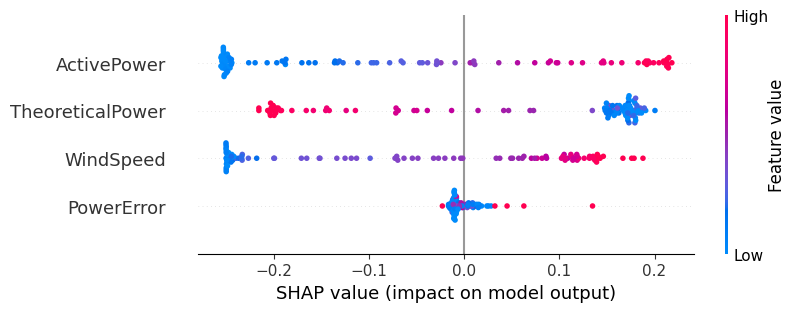

In [17]:
import shap
import matplotlib.pyplot as plt

# Define feature names
feature_names = ['WindSpeed', 'ActivePower', 'TheoreticalPower', 'PowerError']

# Convert scaled arrays to DataFrame to preserve column names
import pandas as pd
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# SHAP explainer
explainer = shap.Explainer(model, X_train_df)
shap_values = explainer(X_test_df[:100])

# Start capturing the plot
plt.figure()  # Start new figure

# Plot SHAP beeswarm
shap.plots.beeswarm(shap_values, show=False)

# Save plot
plt.savefig("shap_beeswarm_plot.png", dpi=300, bbox_inches='tight')

# Show plot in notebook
plt.show()
